In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../..')
import mutagenesisfunctions as mf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
#from Bio import AlignIO
import time as time
import pandas as pd
import bpdev as bp

In [2]:
def bp_coords(ugSS, mir = True):
    '''
    Function that takes in an ungapped Sequence string and
    outputs a list of lists with the coordinates base pairs.
    Optionally it can also output the list extended with the 
    reflections of the coordinates for use with holistics 
    plots.
    '''

    bp_openers = ['(', '<', '{']
    bp_closers = [')', '>', '}']

    basepairs = [] #list to hold the base pair coords
    opened = np.array([]) # holds the integers of chars and keeps track of how close they are to being closed
    counter = 0
    for char in ugSS:

        if char in bp_openers:
            #open a base pair and start counting till its closed
            opened = np.append(opened, 0)
            opened += 1

        elif char in bp_closers: 
            #get closer to closing if we find a closing bracket
            opened -= 1
            if 0 in opened:
                #check if we've successfuly closed a pair
                op = np.where(opened ==0)[0][0]
                basepairs.append([op, counter]) #add the pair to our list
                opened[np.where(opened ==0)] = 1000 # make the recently closed char negligible
            opened = np.append(opened, 1000) #treat closing brackets as negligible


        else:
            opened = np.append(opened, 1000) #non-base-paired chars are negligible

        counter += 1
    
    basepairs = np.asarray(basepairs)
    
    #Optional reflection
    if mir:
        reflect = basepairs[:, ::-1]
        basepairs = np.vstack([basepairs, reflect])
    
    return (basepairs)

In [3]:
starttime = time.time()

#Open data from h5py

data_path = '../../data_RFAM/trna_100k_d5.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

#set up dictionaries
train = {'inputs': X_data[shuffle[:split_1]], 
         'targets': Y_data[shuffle[:split_1]]}
valid = {'inputs': X_data[shuffle[split_1:split_2]], 
         'targets': Y_data[shuffle[split_1:split_2]]}
test = {'inputs': X_data[shuffle[split_2:]], 
         'targets': Y_data[shuffle[split_2:]]}
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

Data extraction and dict construction completed in: 25.65s


In [4]:
simalign_file = '../../data_RFAM/trnasim_100k.sto'

#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)

bpSS

'(((((((<<<<>>>><<<<<>>>>><<<<<>>>>>)))))))'

In [5]:
ugSS

'(((((((,,<<<<_______>>>>,<<<<<_______>>>>>,,,,<<<<<_______>>>>>))))))):'

In [8]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    
    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                    # concat, embedding, variational_normal, variational_softmax, + more
          'num_units': 196,
          'norm': 'batch',          # if removed, automatically adds bias instead
          'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
          'dropout': 0.5,           # if removed, default is no dropout
             }

    
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../results/trna'
param_path = os.path.join(save_path, 'resbind_t5')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 513, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: dense_0
(?, 196)
layer17: dense_0_batch
(?, 196)
layer18: dense_0_active
(?, 196)
layer19: dense_0_dropout
(?, 196)
layer20: den

In [10]:
# initialize session
sess = utils.initialize_session()

In [ ]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

In [ ]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]


In [9]:
savepath = 'Arrays/trna_resbind_o_1k.npy'
savepath = 'Arrays/trna_resbind_l_1k.npy'
savepath = 'Arrays/trna_resbind_o_log_1k.npy'
savepath = 'Arrays/trna_resbind_l_log_1k.npy'


## Reference

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


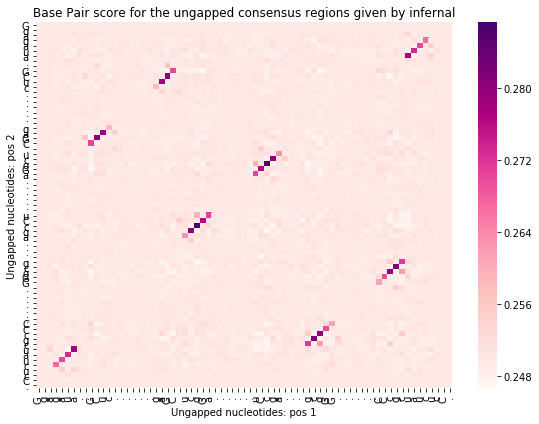

In [31]:
#load values
#savepath = 'Arrays/trna_resbindt5_ug_so1000.npy'
savepath = 'Arrays/trna_resbind_l_1k.npy'
sum_mut2 = np.load(savepath)

#average the values
num_summary = 1
mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4 matrices
meanhol_mut2 = mean_mut2.reshape(numug,numug,dims,dims)

normalize = True
if normalize:
    meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, nntrainer, sess, maxreduce=True, normfactor = 1)
    
    #Let's try something weird
bpfilter = np.ones((4,4))*0
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = 1.
    
C = np.sum((meanhol_mut2*bpfilter).reshape(numug,numug,dims*dims), axis=2)


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(C, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='RdPu', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')


### True Base Pairs as comparison

In [32]:
#Get the base pair coords
bp_rc = bp_coords(ugSS)

#make sure that these are what we expect
s = np.ones_like(C)*-1

for r in bp_rc:
    s[r[0], r[1]] = 1

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


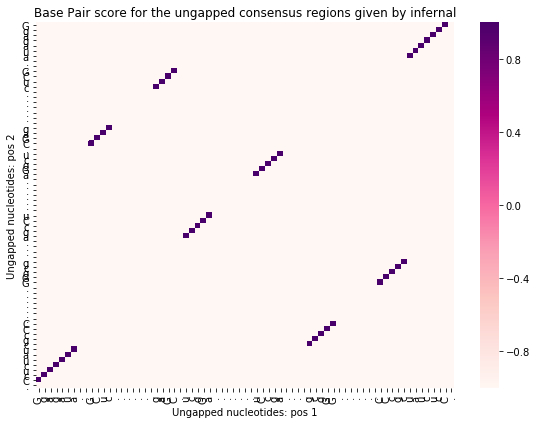

In [33]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(s, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='RdPu', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')

In [13]:
#pull out the base pairs from the holistic scores array
bp_hols = np.zeros((numbp, dims, dims))
  
for i,r in enumerate(bp_rc):
    bp_hols[i] = meanhol_mut2[r[0],r[1]]

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


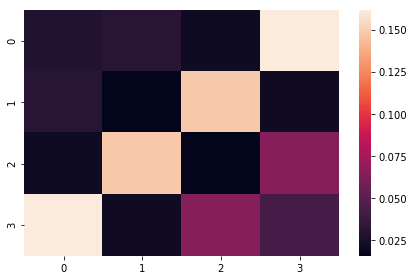

In [14]:
bp_hols_avg = np.mean(bp_hols, axis=0)
plt.figure()
sb.heatmap(bp.makeprob(bp_hols_avg))

## Peter's idea

In [47]:
ac_stretch[bp_index][:550]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [49]:
bp_stretch = np.ravel(C)
ac_stretch = np.ravel(s)

bp_index = np.argsort(bp_stretch)[::-1]
metricstore = []
for bp in bp_index:
    metricstore.append(bp_stretch[bp]*ac_stretch[bp])

metricstore = np.cumsum(metricstore)

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


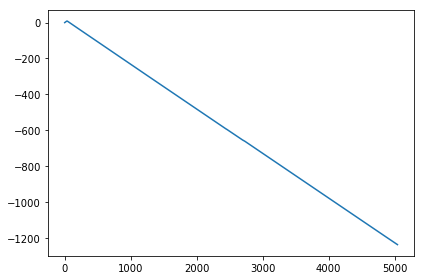

In [51]:
plt.figure()
plt.plot(range(len(metricstore[:])), metricstore[:])

In [45]:
bp_stretch[bp_index[0]]

0.28726376593112946